# TP53 Exploratory Notebook

In [1]:
import pandas as pd
import numpy as np
import re
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import CPTAC

Loading CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter CPTAC.embargo() to open the webpage for more details.


## Set up initial dataframes and variables

In [3]:
gene='TP53'
somatic = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

#A list of mutations present in the hotspot according to our Hotspot3D output
hotspot_mutations = ['p.P250L', 'p.R248W', 'p.S241C', 'p.S241del', 'p.K164E', 'p.R249S', 'p.R273H', 'p.R282W',
                    'p.S127Y', 'p.G244D', 'p.A159P']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]
hotspot_patients = mutated_hotspot['Clinical_Patient_Key']

## Test and plot a single protein

CABLES1: 1.1764566319746612e-05


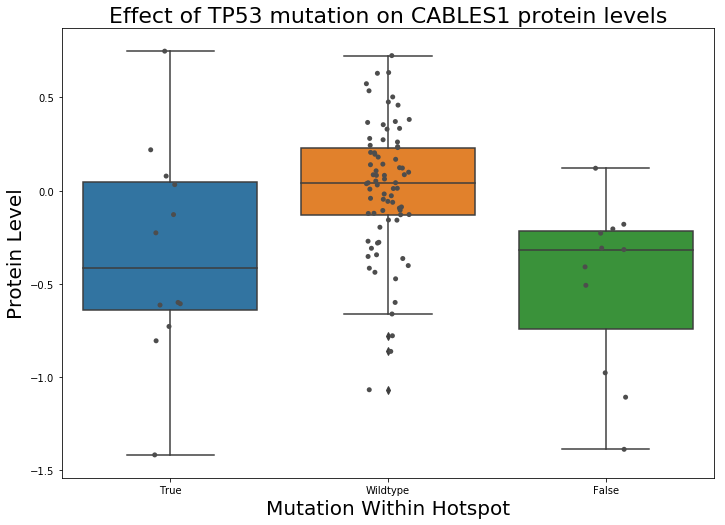

In [45]:
gene = 'TP53'
protein = 'CABLES1'

p53_mutations_protein = CPTAC.compare_mutations(proteomics, protein, gene)
p53_mutations_protein['Within_Hotspot'] = False
p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = True
p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Patient_Type'] == 'Tumor'].dropna(axis=0)
mutated = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] != 'Wildtype']
wt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
if len(mutated) > 2:
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        print(protein + ": " + str(ttest[1]))
else:
    print("There are not enough mutations within the hotspot to do a t-test")
    
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = p53_mutations_protein, x = 'Within_Hotspot', y = protein, ax = ax)
boxplt = sns.stripplot(data = p53_mutations_protein, x = 'Within_Hotspot', y = protein, jitter = True, color = '.3')
boxplt.set_xlabel('Mutation Within Hotspot', fontsize='20')
boxplt.set_ylabel('Protein Level', fontsize='20')
boxplt.set_title("Effect of TP53 mutation on " + protein + " protein levels", fontsize='22')
plt.show()

In [8]:
pcutoff = 0.001
pcutoff

0.001

In [9]:
significant_mut_wt = {}
gene = 'PIK3CA'

for protein in proteomics.columns:
    if (protein != 'idx') and (protein != gene):
        p53_mutations_protein = CPTAC.compare_mutations(proteomics, protein, gene)
        p53_mutations_protein['Within_Hotspot'] = False
        p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Patient_Type'] == 'Tumor'].dropna(axis=0)
        mutated = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] != 'Wildtype']
        wt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
        if len(mutated) < 2: continue
        if len(wt) < 2: continue
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        if ttest[1] <= pcutoff:
            significant_mut_wt[protein] = ttest[1]
            
significant_mut_wt

{'CASP7': 0.00045976572239083514,
 'CCDC25': 0.0004116814302809243,
 'DYRK1B': 0.0004286641068681629,
 'EIF3K': 0.0007121645498727077,
 'GDPGP1': 0.0008954766880749995,
 'PSMA4': 0.0001321921352930831,
 'RRAGC': 0.00031933594717525047}

## Transcriptome differences

Ttest_indResult(statistic=-0.5623695439938743, pvalue=0.5753619906307142)


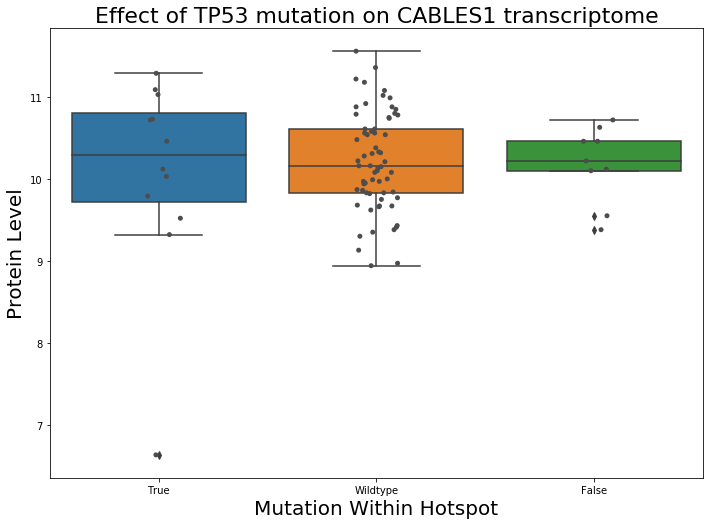

In [52]:
gene = 'TP53'
protein = 'CABLES1'
transcriptomics = CPTAC.get_transcriptomics()

p53_transcript_mut = CPTAC.compare_mutations(proteomics, gene)
p53_transcript_mut['Within_Hotspot'] = False
p53_transcript_mut.loc[hotspot_patients, 'Within_Hotspot'] = True
p53_transcript_mut.loc[p53_transcript_mut['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
p53_transcript_mut = p53_transcript_mut.loc[p53_transcript_mut['Patient_Type'] == 'Tumor'].dropna(axis=0)
prot_transcript = transcriptomics[protein]

transcript_analysis = p53_transcript_mut.join(prot_transcript).drop(gene, axis=1).dropna(axis=0)
transcript_analysis = transcript_analysis.loc[transcript_analysis['Patient_Type'] == 'Tumor']

in_hotspot = transcript_analysis.loc[transcript_analysis['Within_Hotspot'] != 'Wildtype']
outside_hotspot = transcript_analysis.loc[transcript_analysis['Within_Hotspot'] == 'Wildtype']
print(scipy.stats.ttest_ind(in_hotspot[protein], outside_hotspot[protein]))

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = transcript_analysis, x = 'Within_Hotspot', y = protein, ax = ax)
boxplt = sns.stripplot(data = transcript_analysis, x = 'Within_Hotspot', y = protein, jitter = True, color = '.3')
boxplt.set_xlabel('Mutation Within Hotspot', fontsize='20')
boxplt.set_ylabel('Protein Level', fontsize='20')
boxplt.set_title("Effect of TP53 mutation on " + protein + " transcriptome", fontsize='22')
plt.show()